In [22]:
import argparse, os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import cucim
import data.utils_metrics as utils_met
import cucim.skimage.metrics as met

import utils
import data.HCP_dataset_h5_arb as HCP_dataset

7T scan resolution : 173, 207, 173

3T scan resolution : 145, 174, 174

In [23]:
parser = argparse.ArgumentParser(description="IMDN")
parser.add_argument("--block_size", type=tuple, default=(32,32,32),
                    help="Block Size")
parser.add_argument("--test_size", type=tuple, default=(173,207,173),
                    help="test_size")
parser.add_argument("--crop_depth", type=int, default=15,
                    help="crop across z-axis")
parser.add_argument("--dir", type=str,
                    help="dataset_directory")
parser.add_argument("--batch_size", type=int,
                    help="dataset_directory")
parser.add_argument("--sort", type=bool,
                    help="dataset_directory")
parser.add_argument("--debug", type=bool,
                    help="dataset_directory")
parser.add_argument("--preload", type=bool,
                    help="dataset_directory")
parser.add_argument("--scale", type=tuple, default=(1,1,1),
                    help="test_size")
args = list(parser.parse_known_args())[0]
args.preload = True
args.debug = True
args.dir = "/storage"
args.batch_size = 4
args.sort = True
args.typ = 'upsampled'
args.scale = (2,2,2)
print(args)

Namespace(batch_size=4, block_size=(32, 32, 32), crop_depth=15, debug=True, dir='/storage', preload=True, scale=(2, 2, 2), sort=True, test_size=(173, 207, 173), typ='upsampled')


In [24]:
ids = utils.get_ids()
ids.sort()
ids = ids[:5]
dataset_hcp = HCP_dataset
dataset_hcp.load_data(args.dir,ids)
training_dataset = dataset_hcp.hcp_data(args,ids)
testing_dataset = dataset_hcp.hcp_data_test(args,ids)

100610 loaded
102311 loaded
102816 loaded
104416 loaded
105923 loaded
100610 loaded
102311 loaded
102816 loaded
104416 loaded
105923 loaded


In [25]:
training_dataset.set_scale(scale = (1,1,2))

In [26]:
x = training_dataset[0]
print(x[0].shape,x[1].shape,x[2].shape,x[3].shape)

(32, 32, 32, 8) (64, 64, 64) (64, 64, 64) (64, 64, 64, 3)


In [27]:
len(testing_dataset)

5

In [28]:
len(training_dataset)

71

In [29]:
x = testing_dataset[0]
print(x[0].shape,x[1].shape,x[2].shape,x[3].shape)

(145, 174, 145, 8) (173, 207, 173) (173, 207, 173) (173, 207, 173, 3)


In [30]:
x = training_dataset[0]
print(x[0].shape,x[1].shape,x[2].shape,x[3].shape)

(32, 32, 32, 8) (64, 64, 64) (64, 64, 64) (64, 64, 64, 3)


In [31]:
import random

In [32]:
samples

[13, 38, 1, 47, 56, 20]

In [33]:
len(testing_dataset)

5

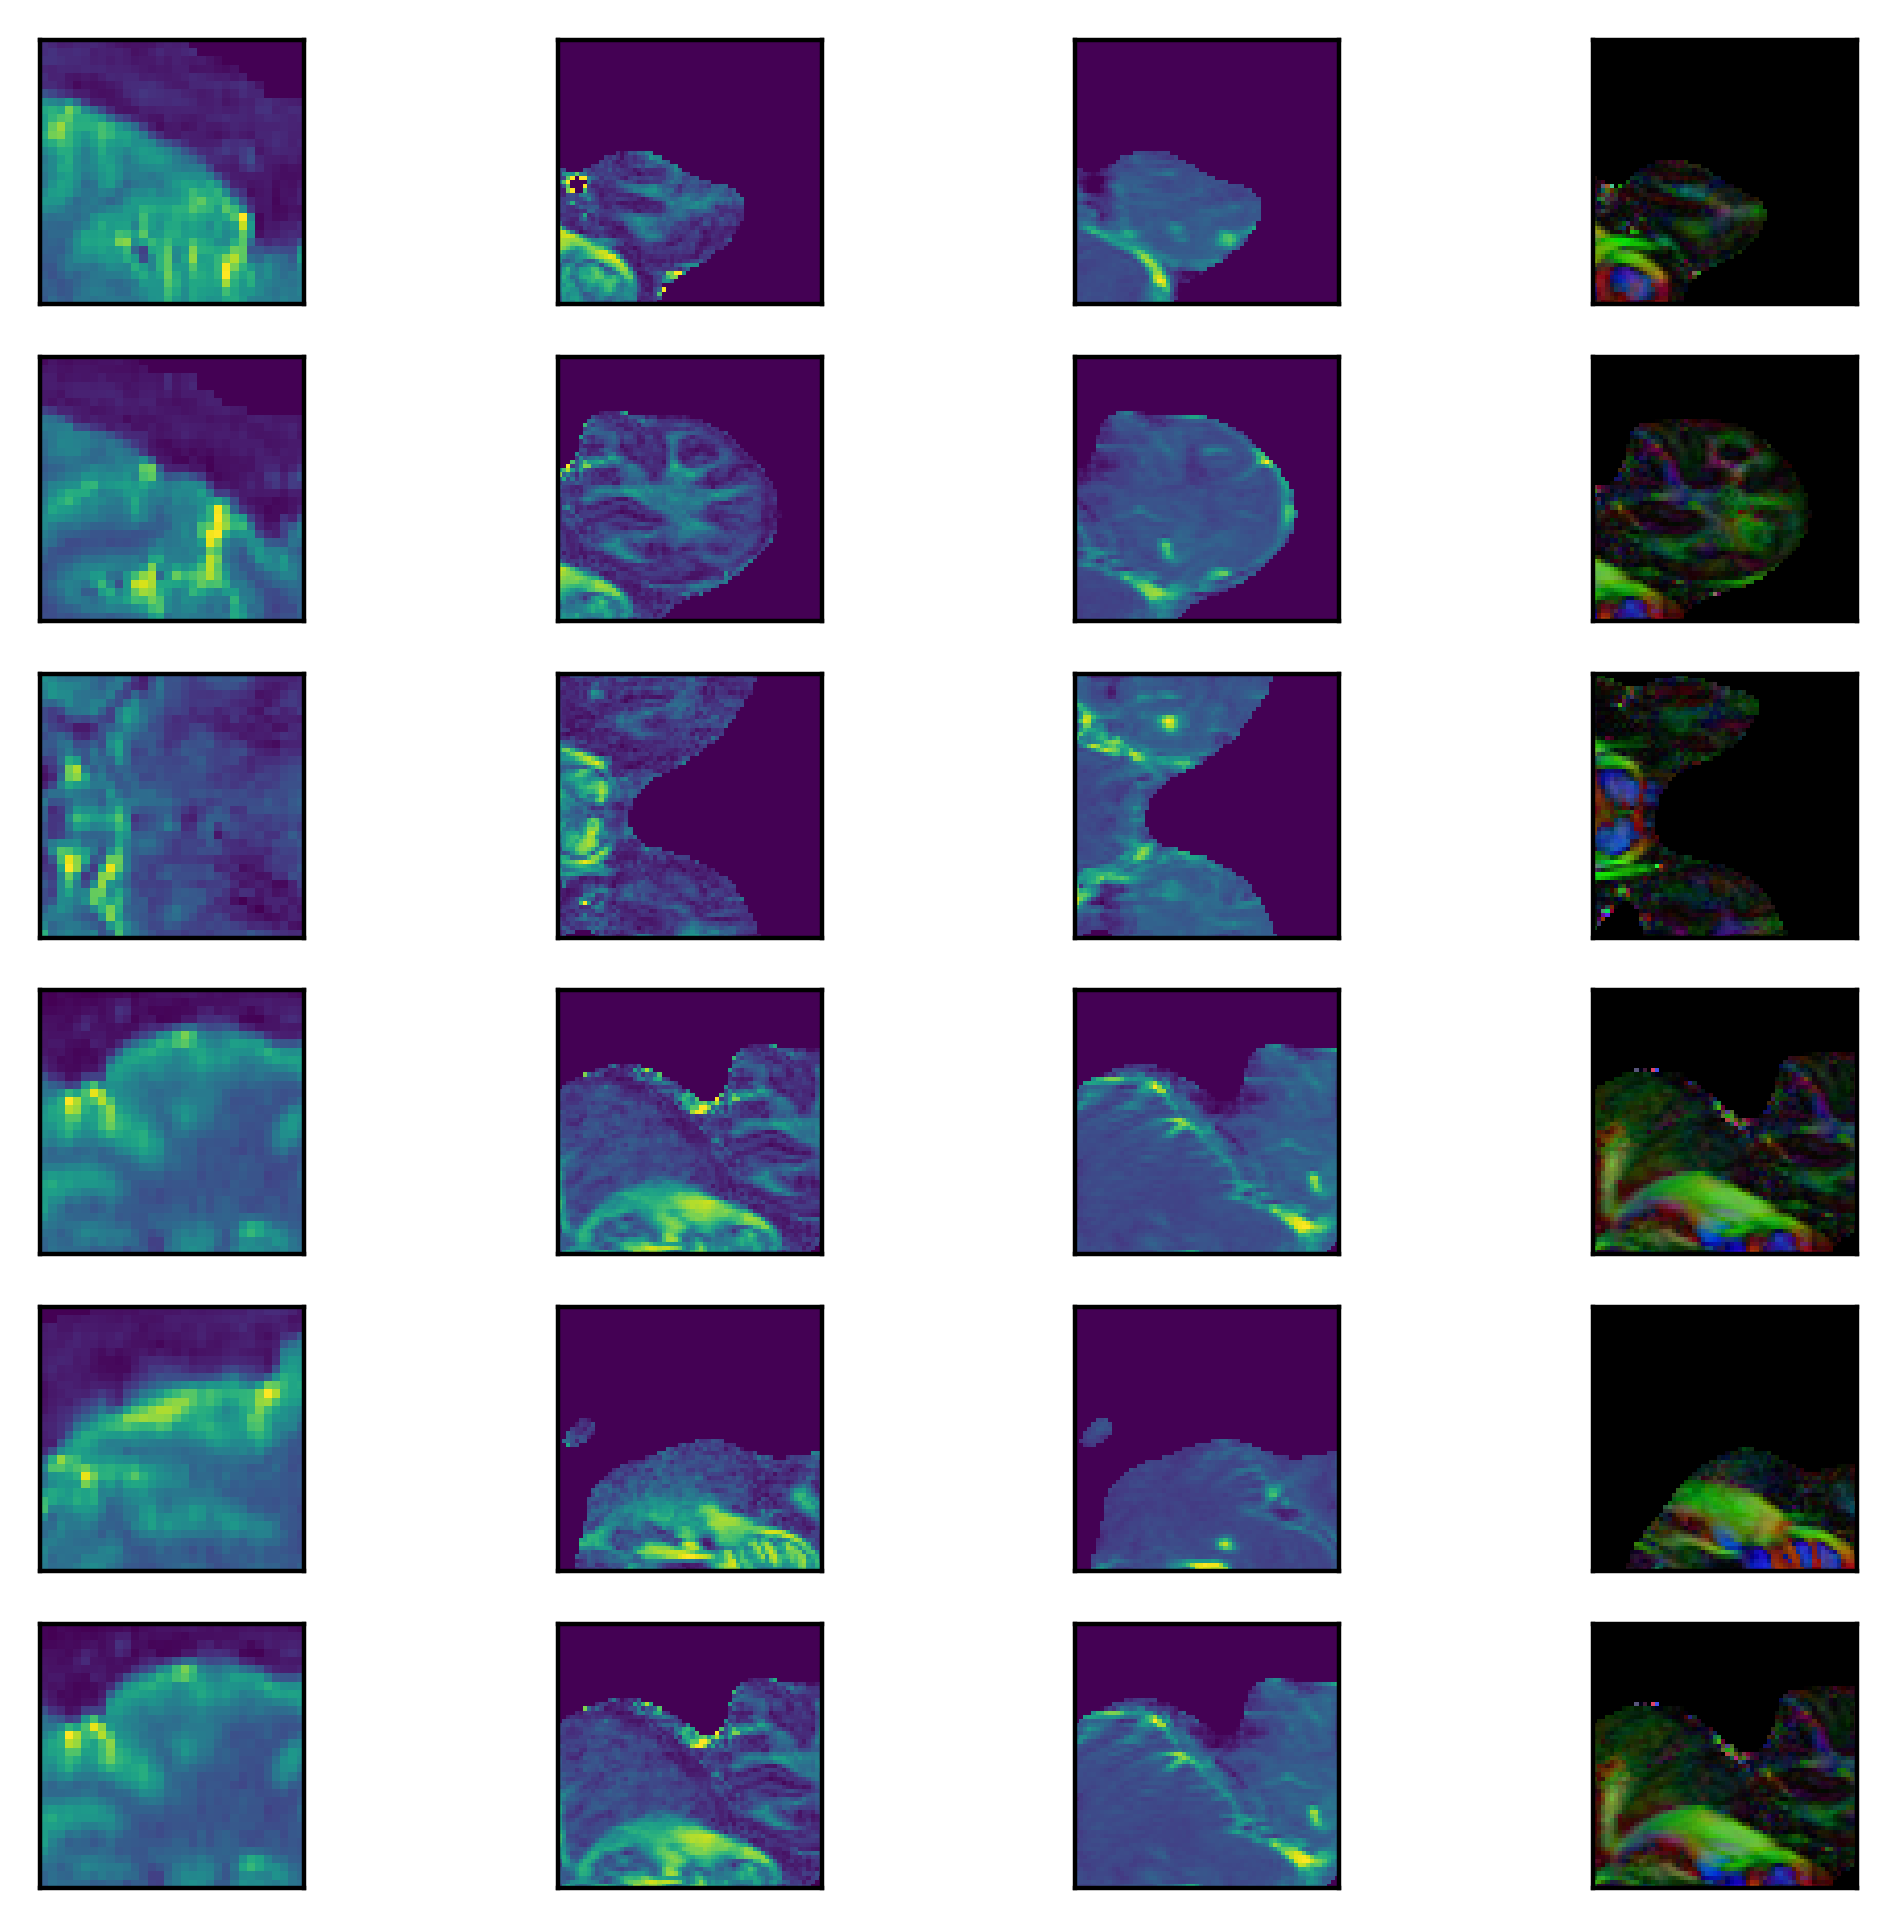

In [34]:
import matplotlib.pyplot as plt
import numpy as np


l = 6

samples = [random.randint(0,len(training_dataset)) for i in range(l)]
f, axarr = plt.subplots(l,4)
# f.set_figwidth(5)
f.set_figheight(l)
f.set_figsize= (4,3)
f.dpi = 400

for i in range(l):
    for j in range(4):
        axarr[i,j].xaxis.set_tick_params(labelbottom=False)
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
        axarr[i,j].yaxis.set_tick_params(labelleft=False)
        pass
k=0
for i in samples:
    axarr[k,0].imshow(training_dataset[i][0][:,:,2,0])
    axarr[k,1].imshow(training_dataset[i][1][:,:,4])
    axarr[k,2].imshow(training_dataset[i][2][:,:,4])
    axarr[k,3].imshow(training_dataset[i][3][:,:,2])
    k+=1

In [35]:
def resize(data):
    x,y = [],[]
    for i in range(len(data)):
        x.append(data[i][0])
        y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
    return torch.from_numpy(np.stack(x)),torch.from_numpy(np.stack(y))

In [53]:
training_data_loader = DataLoader(dataset=training_dataset, batch_size=4, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize)
testing_data_loader = DataLoader(dataset=testing_dataset, batch_size=1,pin_memory=True,collate_fn=resize)

In [54]:
print(len(training_data_loader))

17


In [55]:
len(training_dataset)

71

In [39]:
temp = next(iter(training_data_loader))

In [40]:
temp[0].shape

torch.Size([4, 32, 32, 32, 8])

In [41]:
temp[1].shape

torch.Size([4, 64, 64, 64, 5])

## DUAL ARBNET

In [42]:
from model import rdn
import argparse, os
import numpy as np
import matplotlib.pyplot as plt
import torch
from model import dmri_arb

In [43]:
model = dmri_arb.DMRI_SR()

In [44]:
model

DMRI_SR(
  (encoder): RDN(
    (SFENet1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (SFENet2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (RDBs): ModuleList(
      (0-2): 3 x RDB(
        (convs): Sequential(
          (0): RDB_Conv(
            (conv): Sequential(
              (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (1): ReLU()
            )
          )
          (1): RDB_Conv(
            (conv): Sequential(
              (0): Conv3d(48, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (1): ReLU()
            )
          )
          (2): RDB_Conv(
            (conv): Sequential(
              (0): Conv3d(80, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (1): ReLU()
            )
          )
          (3): RDB_Conv(
            (conv): Sequential(
              (0): Conv3d(112, 32, kernel_size=(3, 3,

In [45]:
temp = next(iter(training_data_loader))
print(temp[0].shape)
inp = torch.permute(temp[0], (0,4,1,2,3))
print(inp.shape)

torch.Size([4, 32, 32, 32, 8])
torch.Size([4, 8, 32, 32, 32])


In [46]:
model.set_scale(scale = (1.2,1.2,1.2))

In [47]:
out = model(inp)

In [48]:
out.shape

torch.Size([4, 5, 38, 38, 38])

In [49]:
out = torch.permute(out, (0,2,3,4,1))
print(out.shape)

torch.Size([4, 38, 38, 38, 5])


In [50]:
temp[1].shape

torch.Size([4, 64, 64, 64, 5])

In [56]:
for iteration, (lr_tensor, hr_tensor) in enumerate(testing_data_loader, 1):
    print(lr_tensor.shape,hr_tensor.shape)

torch.Size([1, 145, 174, 145, 8]) torch.Size([1, 173, 207, 173, 5])
torch.Size([1, 145, 174, 145, 8]) torch.Size([1, 173, 207, 173, 5])
torch.Size([1, 145, 174, 143, 8]) torch.Size([1, 173, 207, 173, 5])
torch.Size([1, 145, 174, 143, 8]) torch.Size([1, 173, 207, 173, 5])
torch.Size([1, 145, 174, 143, 8]) torch.Size([1, 173, 207, 173, 5])
